## importing libraries and files from drive

In [1]:
import pandas as pd
import cv2
import base64
import IPython
import json
import numpy as np
import os
import random
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [4]:
# defining folders for files prepared in the data  preparation notebook , folders are avaibile on github page just copy paste them to your drive
# credit to https://www.datacamp.com/tutorial/sam2-fine-tuning for delivering a full tutorial and code on how to fintune sam 2 model
path = '/content/drive/MyDrive/sam_project/sam_project/'
# path for images
# train set
train_images = os.path.join(path , 'trees.v19i.coco-segmentation/train/images')
train_masks  = os.path.join(path , 'trees.v19i.coco-segmentation/train/masks')
# validation  set
valid_images = os.path.join(path , 'trees.v19i.coco-segmentation/valid/images')
valid_masks  = os.path.join(path , 'trees.v19i.coco-segmentation/valid/masks')
# csv file for annotations
train_df     = pd.read_csv(os.path.join(path , 'training_images_annotation.csv'))
valid_df     = pd.read_csv(os.path.join(path , 'validtion_images_annotation.csv'))


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
valid_df.head()

Unnamed: 0                                              image  \
0           0  trees.v19i.coco-segmentation/valid/images/1-ka...   
1           1  trees.v19i.coco-segmentation/valid/images/1-ki...   
2           2  trees.v19i.coco-segmentation/valid/images/11aa...   
3           3  trees.v19i.coco-segmentation/valid/images/12aa...   
4           4  trees.v19i.coco-segmentation/valid/images/14aa...   

                                                mask  
0  trees.v19i.coco-segmentation/valid/masks/1-kan...  
1  trees.v19i.coco-segmentation/valid/masks/1-kir...  
2  trees.v19i.coco-segmentation/valid/masks/11aa_...  
3  trees.v19i.coco-segmentation/valid/masks/12aa_...  
4  trees.v19i.coco-segmentation/valid/masks/14aa_...

In [6]:
ent = train_df.iloc[np.random.randint(len(train_df))]
ent

Unnamed: 0                                                    7
image         trees.v19i.coco-segmentation/train/images/13aa...
mask          trees.v19i.coco-segmentation/train/masks/13aaa...
Name: 7, dtype: object

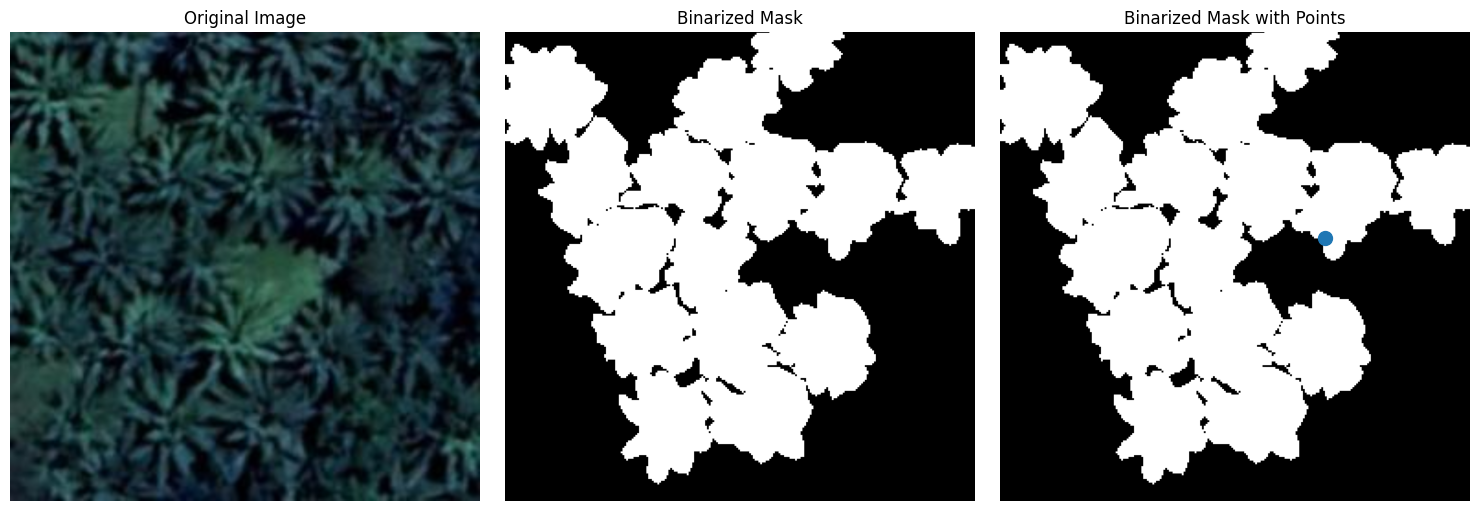

In [7]:
# testing the data
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data.iloc[np.random.randint(len(data))]
    # adding the google colab path
    path = '/content/drive/MyDrive/sam_project/sam_project/'
    # Get full paths for image and annotation
    Img = cv2.imread(path + ent["image"] )[..., ::-1]  # Read image and convert from BGR to RGB
    ann_map = cv2.imread(path + ent["mask"] , cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    # Check if either the image or annotation could not be read
    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Rescale the image and annotation to fit within 1024x1024
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Calculate scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize binary mask and list of points
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Process each unique label in the annotation map (except the background, index 0)
    inds = np.unique(ann_map)[1:]  # Skip the background label
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Binary mask for the current label
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid selecting boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])  # Append x, y (note reverse order)

    # Convert points to a NumPy array
    points = np.array(points)

    # Visualization (if requested)
    if visualize_data:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Binary mask
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Binary mask with points
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Expand binary mask dimensions for consistency
    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Shape becomes (H, W, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))  # Convert to (1, H, W)
    points = np.expand_dims(points, axis=1)  # Shape becomes (num_points, 1, 2)

    # Return the processed data
    return Img, binary_mask, points, len(inds)

# Example usage
# Ensure df is a DataFrame or list-like object containing image paths and annotation paths
Img1, masks1, points1, num_masks = read_batch(train_df , visualize_data=True)

## importing and preparing sam 2 model

In [8]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 974 (delta 237), reused 222 (delta 222), pack-reused 605 (from 1)
Receiving objects: 100% (974/974), 121.67 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (340/340), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:0

In [10]:
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"

--2024-12-05 21:14:13--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323493298 (309M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_base_plus.pt’

sam2_hiera_base_plu 100%[===================>] 308.51M   286MB/s    in 1.1s    

2024-12-05 21:14:14 (286 MB/s) - ‘sam2_hiera_base_plus.pt’ saved [323493298/323493298]



## setting up model and optimizers

In [11]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


sam2_checkpoint = "sam2_hiera_base_plus.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_b+.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)


In [12]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(False)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "sam_palm"


In [13]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_df, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = path + FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.34585977620633546
Step 200:	 Accuracy (IoU) =  0.4970944445915149
Step 300:	 Accuracy (IoU) =  0.6079571679338407
Step 400:	 Accuracy (IoU) =  0.6518403539958222
Step 500:	 Accuracy (IoU) =  0.6771749946574532
Step 600:	 Accuracy (IoU) =  0.69188893110274
Step 700:	 Accuracy (IoU) =  0.6963218506113757
Step 800:	 Accuracy (IoU) =  0.6858997507294579
Step 900:	 Accuracy (IoU) =  0.6956495130075031
Step 1000:	 Accuracy (IoU) =  0.6983098908668204
Step 1100:	 Accuracy (IoU) =  0.6911774902890885
Step 1200:	 Accuracy (IoU) =  0.6888391981673313
Step 1300:	 Accuracy (IoU) =  0.6918380162889797
Step 1400:	 Accuracy (IoU) =  0.6887378258586502
Step 1500:	 Accuracy (IoU) =  0.6921871980485215
Step 1600:	 Accuracy (IoU) =  0.6908977470810441
Step 1700:	 Accuracy (IoU) =  0.6869713217972275
Step 1800:	 Accuracy (IoU) =  0.6901719882130488
Step 1900:	 Accuracy (IoU) =  0.6953487656605357
Step 2000:	 Accuracy (IoU) =  0.7020220154508808
Step 2100:	 Accuracy (IoU) =  

## result verification

In [14]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [ ]:
path = '/content/drive/MyDrive/sam_project/sam_project/

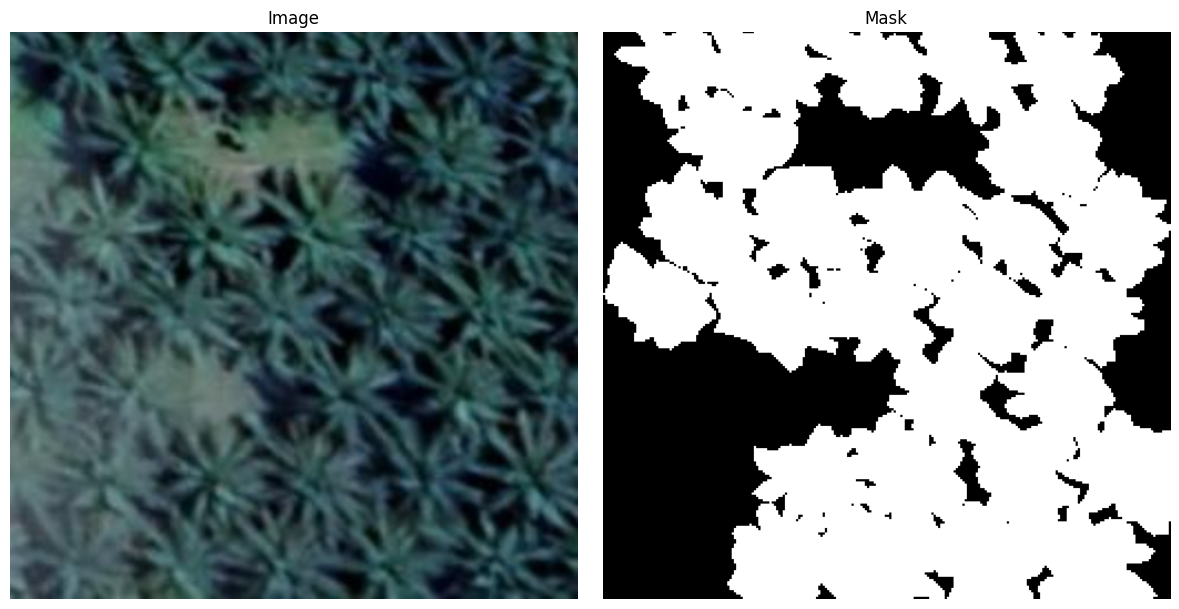

In [21]:
selected_entry = valid_df.iloc[23]
import matplotlib.pyplot as plt

# Chemin des fichiers image et masque
image_path = path + selected_entry['image']
mask_path = path + selected_entry['mask']

# Lecture de l'image et du masque
image, mask = read_image(image_path, mask_path)

# Affichage côte à côte
plt.figure(figsize=(12, 6))

# Image originale
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.axis("off")

# Masque correspondant
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


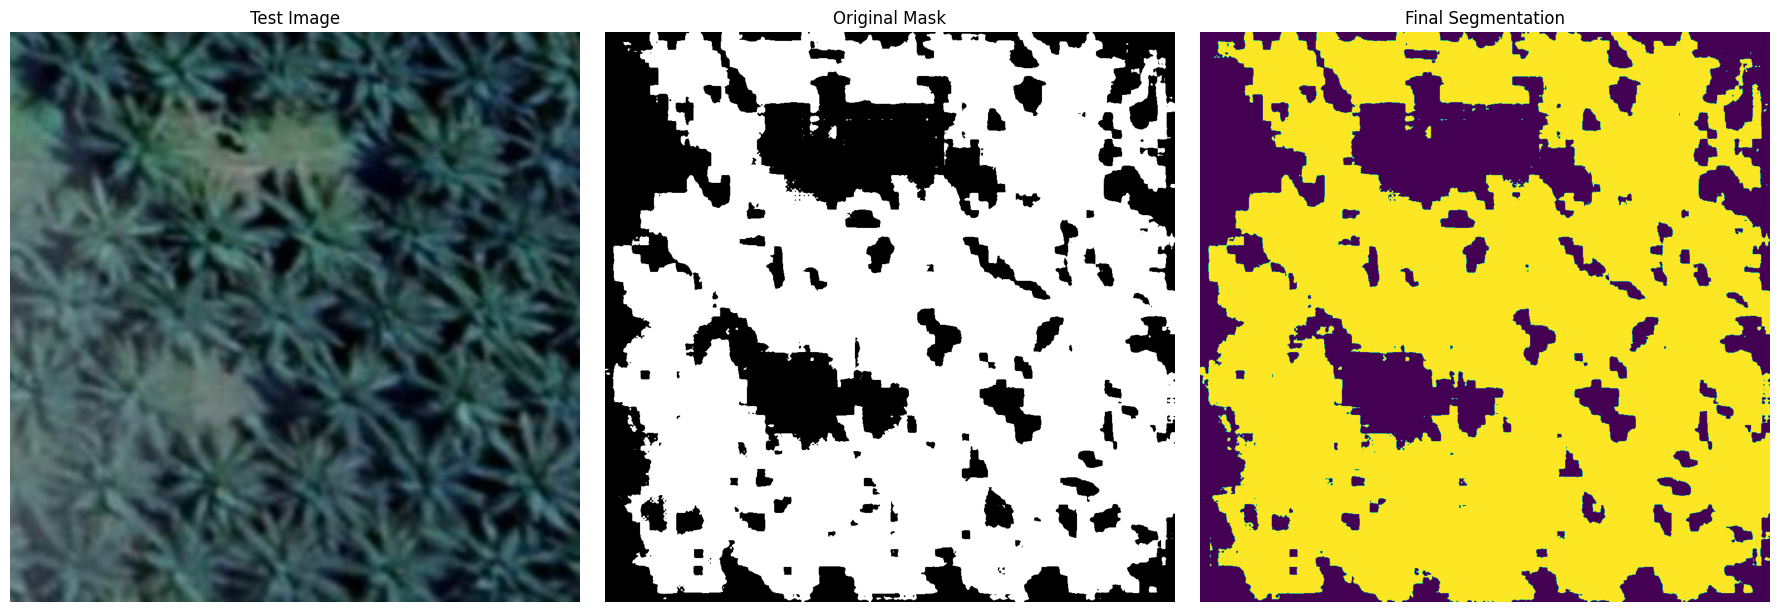

In [22]:
#
image_path = selected_entry['image']
mask_path = selected_entry['mask']

# Load the selected image and mask
image, mask = read_image(path + image_path, path + mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS ="/content/drive/MyDrive/sam_project/sam_project/sam_palm_3000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map)
plt.axis('off')

plt.tight_layout()
plt.show()

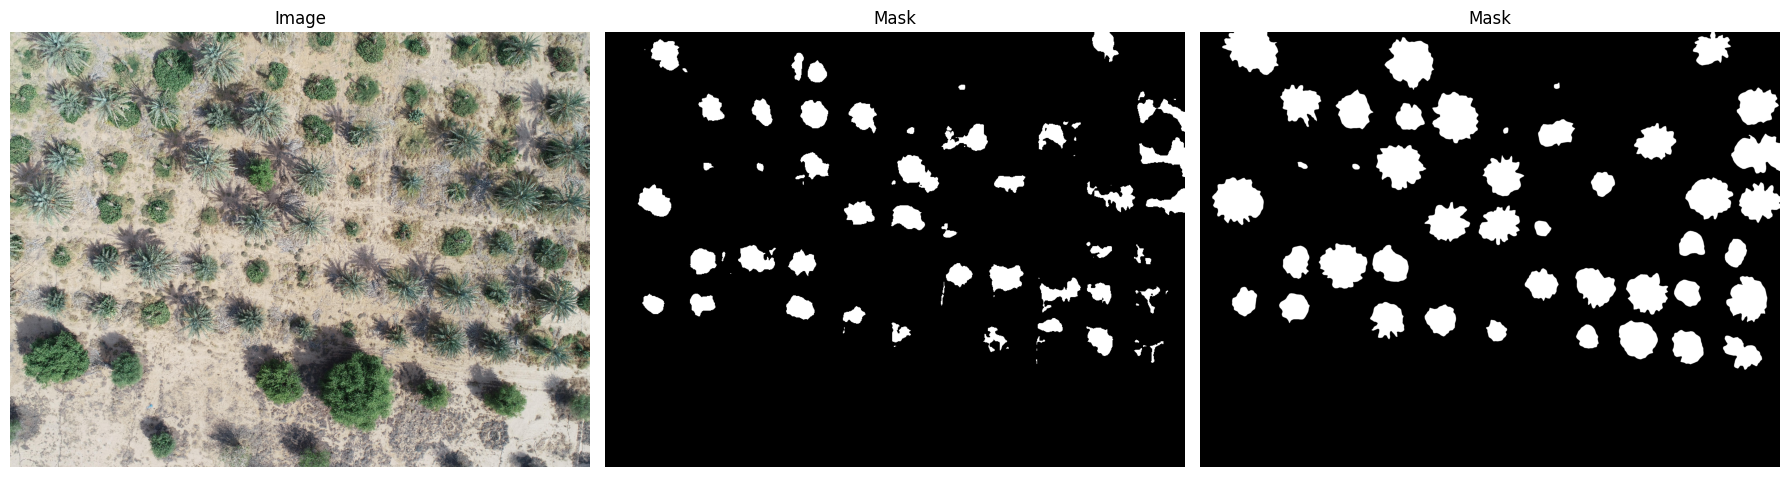

In [23]:
# testing the model on my drone image source

selected_entry = valid_df.iloc[0]
import matplotlib.pyplot as plt

# Chemin des fichiers image et masque
image_path = "/content/ck2ej1sehu1pn07946turgr8z.jpg"
mask_path = "/content/ck2ej1sehu1pn07946turgr8z_mask.jpg"
true_mask_path = "/content/ck2ej1sehu1pn07946turgr8z_mask (1).jpg"
# Lecture de l'image et du masque
image, mask = read_image(image_path, mask_path)
true_mask = cv2.imread(true_mask_path, 0)
#

# Affichage côte à côte
plt.figure(figsize=(18, 6))

# Image originale
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(image)
plt.axis("off")

# Masque correspondant
plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")
##
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(true_mask, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


## testing on my pretrained sam2 model for palms

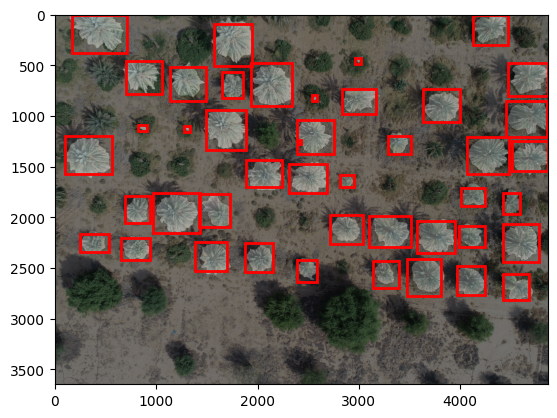

In [24]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
IMAGE_PATH = '/content/ck2ej1sehu1pn07946turgr8z.jpg'
image_rgb = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)
# Assuming mask_predictor is already initialized
# ... (your existing code for mask prediction) ...
with open("/content/ck2ej1sehu1pn07946turgr8z.json", "r") as file:  # Replace 'data.json' with your actual filename
    data = json.load(file)
bboxes = [item["bbox"] for item in data["propreties"]]
        # Print the extracted bboxes
masks_ = np.zeros(image_rgb.shape[:2])
for bbox  in (bboxes):
        bbox_prompt = np.array([ bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax'] ])
        # Predict mask with bounding box prompt
        masks, scores, logits = predictor.predict(
            box=bbox_prompt,
            multimask_output=False
        )
        masks_ = masks_  + masks[0]
# Plot the bounding box prompt and predicted mask
plt.imshow(image_rgb)
# Overlay the mask with transparency
plt.imshow(masks_, alpha=0.5, cmap='gray')  # Use cmap='gray' for the mask
# Add the bounding box
for bbox  in (bboxes):

        bbox_prompt = np.array([ bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax'] ])
        # Predict mask with bounding box prompt
        plt.gca().add_patch(plt.Rectangle((bbox_prompt[0], bbox_prompt[1]),
                                          bbox_prompt[2] - bbox_prompt[0],
                                          bbox_prompt[3] - bbox_prompt[1],
                                          edgecolor='red', facecolor='none', linewidth=2))
plt.show()

## side to side comparaison of mask genrated by

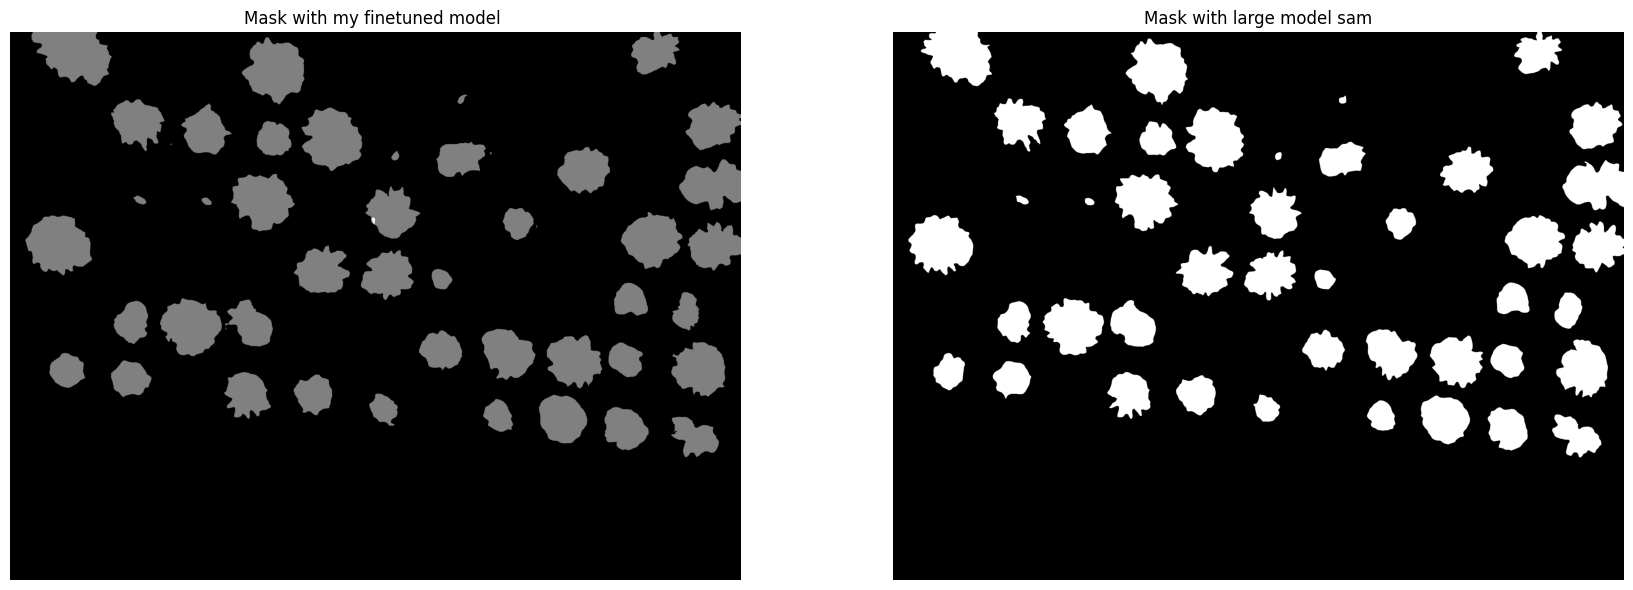

In [27]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.title("Mask with my finetuned model ")
plt.imshow(masks_, cmap="gray")
plt.axis("off")
##
plt.subplot(1, 2, 2)
plt.title("Mask with large model sam")
plt.imshow(true_mask, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


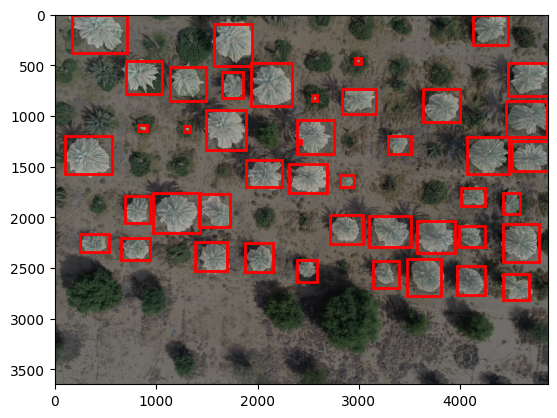

In [31]:
#prediction on the new image
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
IMAGE_PATH = '/content/ck2ej1sehu1pn07946turgr8z.jpg'
image_rgb = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
b_predictor = SAM2ImagePredictor(sam2_model)

b_predictor.set_image(image_rgb)
# Assuming mask_b_predictor is already initialized
# ... (your existing code for mask prediction) ...
with open("/content/ck2ej1sehu1pn07946turgr8z.json", "r") as file:  # Replace 'data.json' with your actual filename
    data = json.load(file)
bboxes = [item["bbox"] for item in data["propreties"]]
        # Print the extracted bboxes
masks_ = np.zeros(image_rgb.shape[:2])
for bbox  in (bboxes):
        bbox_prompt = np.array([ bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax'] ])
        # Predict mask with bounding box prompt
        masks, scores, logits = b_predictor.predict(
            box=bbox_prompt,
            multimask_output=False
        )
        masks_ = masks_  + masks[0]
# Plot the bounding box prompt and predicted mask
plt.imshow(image_rgb)
# Overlay the mask with transparency
plt.imshow(masks_, alpha=0.5, cmap='gray')  # Use cmap='gray' for the mask
# Add the bounding box
for bbox  in (bboxes):

        bbox_prompt = np.array([ bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax'] ])
        # Predict mask with bounding box prompt
        plt.gca().add_patch(plt.Rectangle((bbox_prompt[0], bbox_prompt[1]),
                                          bbox_prompt[2] - bbox_prompt[0],
                                          bbox_prompt[3] - bbox_prompt[1],
                                          edgecolor='red', facecolor='none', linewidth=2))
plt.show()
